# Jupyter notebook to visualize our results after training PyTorch model

Please run this notebook from the notebooks directory.

Some useful links:
- https://brandonrozek.com/blog/jupyterwithpyenv/

- https://github.com/microsoft/vscode-jupyter/wiki/Setting-Up-Run-by-Line-and-Debugging-for-Notebooks

In [1]:
!python --version

Python 3.10.6


In [2]:
import sys

sys.path.append('../')
sys.path.append('../src')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from hydra import initialize, compose
from omegaconf import OmegaConf
from pathlib import Path
from src import *
from src.trainer import Trainer


with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name='trainer.yaml')

    cfg.wandb.mode = "disabled"
    root_filename = "../" + cfg.dataset.filename
    
    ## Save dataset or load it if already saved (but
    # it might not be up to date)
    p = Path(root_filename)
    filename =  f"{str(p.parent)}/{p.stem}_dataset.pkl"
    if Path(filename).is_file():  # if exists and is a file
        cfg.dataset.filename = filename
    else:
        cfg.dataset.filename = root_filename
        cfg.dataset.save_format = "pkl"  # to save dataset

    trainer = Trainer(cfg)

    ### Loading checkpoint
    general_checkpoint = torch.load("../checkpoints/last_general_checkpoint.pth")
    trainer.model.load_state_dict(general_checkpoint["model_state_dict"])
    trainer.optimizer.load_state_dict(general_checkpoint["optimizer_state_dict"])

    trainer.epoch = general_checkpoint["epoch"]
    torch.train_loss = general_checkpoint["train_loss"]
    torch.val_loss = general_checkpoint["val_loss"]
    
    trainer.model.eval()
    torch.set_grad_enabled(False)
    # it helps with memory-related issues:
    # https://stackoverflow.com/questions/69007342/disable-grad-and-backward-globally
    # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879/15
    
    print(OmegaConf.to_yaml(cfg))


Config:
wandb:
  project: POLAR-background-prediction
  mode: disabled
wandb_watch: true
common:
  seed: 42
  n_epochs: 200
  loss:
    name: weighted_mse_loss
    weights:
    - 1/rate_err[0]**2
    - 1/rate_err[1]**2
    - 1/rate_err[5]**2
    - 1/rate_err[6]**2
    - 1/rate_err[10]**2
    - 1/rate_err[12]**2
  device: cuda
dataset:
  filename: ../data/nf1rate_dataset.pkl
  save_format: null
  new_columns:
  - rate_err[0]
  - rate_err[1]
  - rate_err[5]
  - rate_err[6]
  - rate_err[10]
  - rate_err[12]
  - 1/rate_err[0]**2
  - 1/rate_err[1]**2
  - 1/rate_err[5]**2
  - 1/rate_err[6]**2
  - 1/rate_err[10]**2
  - 1/rate_err[12]**2
  - rate[0]/rate_err[0]
  - rate[1]/rate_err[1]
  - rate[5]/rate_err[5]
  - rate[6]/rate_err[6]
  - rate[10]/rate_err[10]
  - rate[12]/rate_err[12]
  - (unix_time-1474004181.5460)//5535.4+10
  feature_names:
  - (unix_time-1474004181.5460)//5535.4+10
  - glat
  - glon
  - altitude
  - temperature
  - fe_cosmic
  - raz
  - decz
  - rax
  - decx
  - is_orbit_up


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using weighted_mse_loss
wandb:
  project: POLAR-background-prediction
  mode: disabled
wandb_watch: true
common:
  seed: 42
  n_epochs: 200
  loss:
    name: weighted_mse_loss
    weights:
    - 1/rate_err[0]**2
    - 1/rate_err[1]**2
    - 1/rate_err[5]**2
    - 1/rate_err[6]**2
    - 1/rate_err[10]**2
    - 1/rate_err[12]**2
  device: cuda
dataset:
  filename: ../data/nf1rate_dataset.pkl
  save_format: null
  new_columns:
  - rate_err[0]
  - rate_err[1]
  - rate_err[5]
  - rate_err[6]
  - rate_err[10]
  - rate_err[12]
  - 1/rate_err[0]**2
  - 1/rate_err[1]**2
  - 1/rate_err[5]**2
  - 1/rate_err[6]**2
  - 1/rate_err[10]**2
  - 1/rate_err[12]**2
  - rate[0]/rate_err[0]
  - rate[1]/rate_err[1]
  - rate[5]/rate_err[5]
  - rate[6]/rate_err[6]
  - rate[10]/rate_err[10]
  - rate[12]/rate_err[12]
  - (unix_time-1474004181.5460)//5535.4+10
  feature_names:
  - (unix_time-1474004181.5460)//5535.4+10
  - glat
  - glon
  - altitude
  - temperature
  - fe_cosmic
  - raz
  - decz
  - rax
  - decx


In [4]:
trainer.dataset_full.data_df

,unix_time,glat,glon,altitude,temperature,fe_cosmic,corrected,correrr,config,raz,...,1/rate_err[6]**2,1/rate_err[10]**2,1/rate_err[12]**2,rate[0]/rate_err[0],rate[1]/rate_err[1],rate[5]/rate_err[5],rate[6]/rate_err[6],rate[10]/rate_err[10],rate[12]/rate_err[12],(unix_time-1474004181.5460)//5535.4+10
0,1.483525e+09,41.273513,64.930544,376.565432,33.500000,1177.0,1111.225454,0.0,42,335.977594,...,0.000364,0.000260,0.000270,28.621580,22.109620,54.603536,49.826243,58.944945,57.878622,1730.0
1,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1077.260702,0.0,42,336.125659,...,0.000348,0.000256,0.000257,27.929632,21.788451,54.791671,50.310019,58.843234,58.802215,1730.0
2,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1067.501924,0.0,42,336.125659,...,0.000348,0.000252,0.000253,27.636904,21.803819,54.403405,50.046106,58.948036,58.898361,1730.0
3,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1108.812904,0.0,42,336.273850,...,0.000343,0.000246,0.000247,28.166676,21.966212,55.363248,50.761011,60.010819,59.940325,1730.0
4,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1110.524550,0.0,42,336.273850,...,0.000349,0.000251,0.000252,28.515913,22.481051,55.182131,50.641369,59.763522,59.708677,1730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956641,1.489745e+09,-42.757777,126.189354,386.590141,34.400002,24460.0,1946.386405,0.0,42,91.466481,...,0.000197,0.000132,0.000132,39.073977,29.911732,73.389050,66.531368,80.931946,80.931946,2853.0
3956642,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,2020.254206,0.0,42,91.614903,...,0.000191,0.000130,0.000130,40.109691,31.212337,74.295432,67.827269,81.857269,81.857269,2853.0
3956643,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,1960.692600,0.0,42,91.614903,...,0.000197,0.000133,0.000133,39.401131,30.389685,73.269094,66.799552,81.149886,81.139297,2853.0
3956644,1.489745e+09,-42.759779,126.527354,386.562382,34.400002,24223.0,2001.103329,0.0,42,91.763169,...,0.000202,0.000133,0.000133,39.691491,30.651826,72.450085,65.728584,80.722957,80.711165,2853.0


In [5]:
# init trainer with a dataset that doesn't filter out the
# GRBs -> we only use it to obtain the dataset with GRBs
# make take some time as it recreates the dataset
cfg.dataset.filename = root_filename
cfg.dataset.save_format = None
cfg.dataset.filter_conditions = ["rate[0]/rate_err[0] > 20"]
trainer_with_GRBs = Trainer(cfg)
dataset_full_GRBs = trainer_with_GRBs.dataset_full
dataset_full_GRBs.data_df

Config:
wandb:
  project: POLAR-background-prediction
  mode: disabled
wandb_watch: true
common:
  seed: 42
  n_epochs: 200
  loss:
    name: weighted_mse_loss
    weights:
    - 1/rate_err[0]**2
    - 1/rate_err[1]**2
    - 1/rate_err[5]**2
    - 1/rate_err[6]**2
    - 1/rate_err[10]**2
    - 1/rate_err[12]**2
  device: cuda
dataset:
  filename: ../data/nf1rate.root
  save_format: null
  new_columns:
  - rate_err[0]
  - rate_err[1]
  - rate_err[5]
  - rate_err[6]
  - rate_err[10]
  - rate_err[12]
  - 1/rate_err[0]**2
  - 1/rate_err[1]**2
  - 1/rate_err[5]**2
  - 1/rate_err[6]**2
  - 1/rate_err[10]**2
  - 1/rate_err[12]**2
  - rate[0]/rate_err[0]
  - rate[1]/rate_err[1]
  - rate[5]/rate_err[5]
  - rate[6]/rate_err[6]
  - rate[10]/rate_err[10]
  - rate[12]/rate_err[12]
  - (unix_time-1474004181.5460)//5535.4+10
  feature_names:
  - (unix_time-1474004181.5460)//5535.4+10
  - glat
  - glon
  - altitude
  - temperature
  - fe_cosmic
  - raz
  - decz
  - rax
  - decx
  - is_orbit_up
  - tim


Expr to eval for col rate_err[0]: data_df['rate_err[0]'].values
Number of examples before filtering:  3956646
Number of examples after filtering (if happened):  3937320

Expr to eval for col rate_err[1]: data_df['rate_err[1]'].values
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col rate_err[5]: data_df['rate_err[5]'].values
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col rate_err[6]: data_df['rate_err[6]'].values
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col rate_err[10]: data_df['rate_err[10]'].values
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col rate_err[12]: data_df['rate_err[12]'].values
Number of examples before filtering:  3937320
Number of examples after filtering 

<string>:1: RuntimeWarning: divide by zero encountered in divide


Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col 1/rate_err[1]**2: 1/data_df['rate_err[1]'].values**2
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col 1/rate_err[5]**2: 1/data_df['rate_err[5]'].values**2
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col 1/rate_err[6]**2: 1/data_df['rate_err[6]'].values**2
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col 1/rate_err[10]**2: 1/data_df['rate_err[10]'].values**2
Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3937320

Expr to eval for col 1/rate_err[12]**2: 1/data_df['rate_err[12]'].values**2
Number of examples before filtering:  3937320
Number of examples after filtering (if happened): 

<string>:1: RuntimeWarning: invalid value encountered in divide


Number of examples before filtering:  3937320
Number of examples after filtering (if happened):  3936212

Expr to eval for col rate[1]/rate_err[1]: data_df['rate[1]'].values/data_df['rate_err[1]'].values
Number of examples before filtering:  3936212
Number of examples after filtering (if happened):  3936211

Expr to eval for col rate[5]/rate_err[5]: data_df['rate[5]'].values/data_df['rate_err[5]'].values
Number of examples before filtering:  3936211
Number of examples after filtering (if happened):  3936211

Expr to eval for col rate[6]/rate_err[6]: data_df['rate[6]'].values/data_df['rate_err[6]'].values
Number of examples before filtering:  3936211
Number of examples after filtering (if happened):  3936211

Expr to eval for col rate[10]/rate_err[10]: data_df['rate[10]'].values/data_df['rate_err[10]'].values
Number of examples before filtering:  3936211
Number of examples after filtering (if happened):  3936211

Expr to eval for col rate[12]/rate_err[12]: data_df['rate[12]'].values/dat

,unix_time,glat,glon,altitude,temperature,fe_cosmic,corrected,correrr,config,raz,...,1/rate_err[6]**2,1/rate_err[10]**2,1/rate_err[12]**2,rate[0]/rate_err[0],rate[1]/rate_err[1],rate[5]/rate_err[5],rate[6]/rate_err[6],rate[10]/rate_err[10],rate[12]/rate_err[12],(unix_time-1474004181.5460)//5535.4+10
0,1.483525e+09,41.273513,64.930544,376.565432,33.500000,1177.0,1111.225454,0.0,42,335.977594,...,0.000364,0.000260,0.000270,28.621580,22.109620,54.603536,49.826243,58.944945,57.878622,1730.0
1,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1077.260702,0.0,42,336.125659,...,0.000348,0.000256,0.000257,27.929632,21.788451,54.791671,50.310019,58.843234,58.802215,1730.0
2,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1067.501924,0.0,42,336.125659,...,0.000348,0.000252,0.000253,27.636904,21.803819,54.403405,50.046106,58.948036,58.898361,1730.0
3,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1108.812904,0.0,42,336.273850,...,0.000343,0.000246,0.000247,28.166676,21.966212,55.363248,50.761011,60.010819,59.940325,1730.0
4,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1110.524550,0.0,42,336.273850,...,0.000349,0.000251,0.000252,28.515913,22.481051,55.182131,50.641369,59.763522,59.708677,1730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956641,1.489745e+09,-42.757777,126.189354,386.590141,34.400002,24460.0,1946.386405,0.0,42,91.466481,...,0.000197,0.000132,0.000132,39.073977,29.911732,73.389050,66.531368,80.931946,80.931946,2853.0
3956642,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,2020.254206,0.0,42,91.614903,...,0.000191,0.000130,0.000130,40.109691,31.212337,74.295432,67.827269,81.857269,81.857269,2853.0
3956643,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,1960.692600,0.0,42,91.614903,...,0.000197,0.000133,0.000133,39.401131,30.389685,73.269094,66.799552,81.149886,81.139297,2853.0
3956644,1.489745e+09,-42.759779,126.527354,386.562382,34.400002,24223.0,2001.103329,0.0,42,91.763169,...,0.000202,0.000133,0.000133,39.691491,30.651826,72.450085,65.728584,80.722957,80.711165,2853.0


In [6]:

from torch.utils.data import Subset
## Prediction on full dataset with GRBs (e.g rate[0])
# Need to transform before inputting the whole set into
# the model
X = dataset_full_GRBs.X_cpu
dataset_tensor = dataset_full_GRBs.transform(X).to(device=cfg.common.device)

pred = trainer.model(dataset_tensor)  # apply the model trained without GRBs on
# whole dataset including GRBs.

dataset_tensor.to(device="cpu")
del dataset_tensor

data_df = dataset_full_GRBs.data_df
subset_dataset_full_GRBs = Subset(dataset_full_GRBs,
                                  indices=range(dataset_full_GRBs.n_examples))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


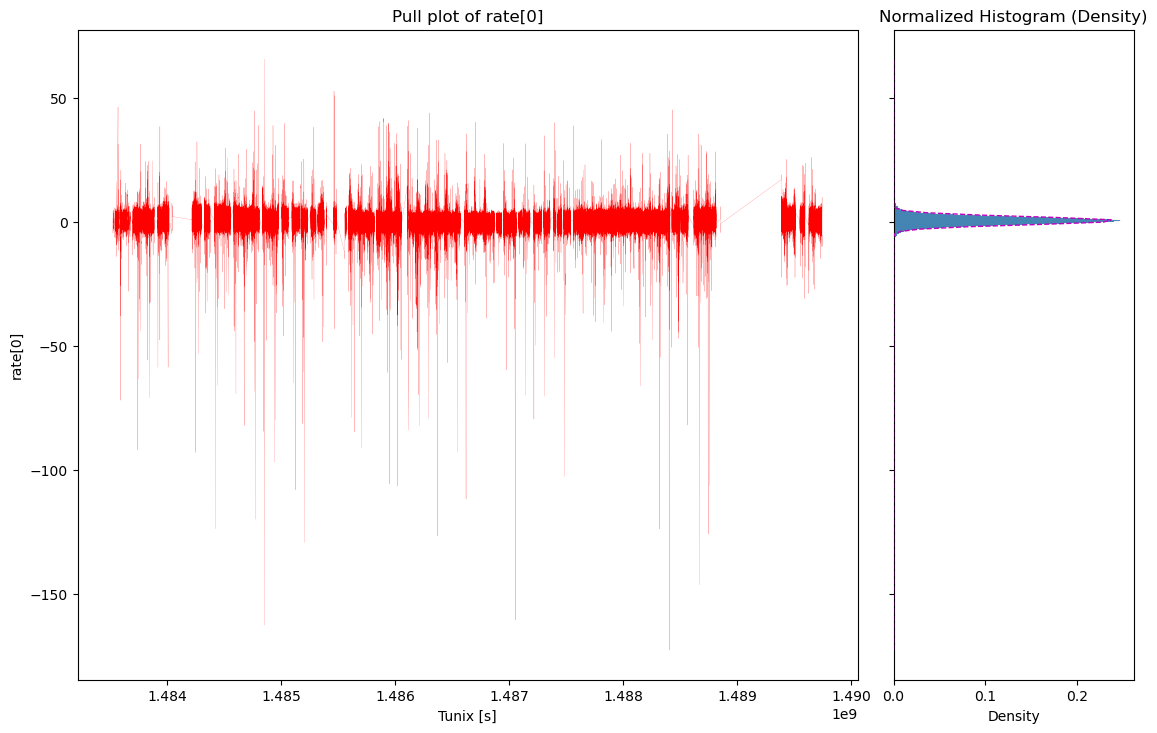

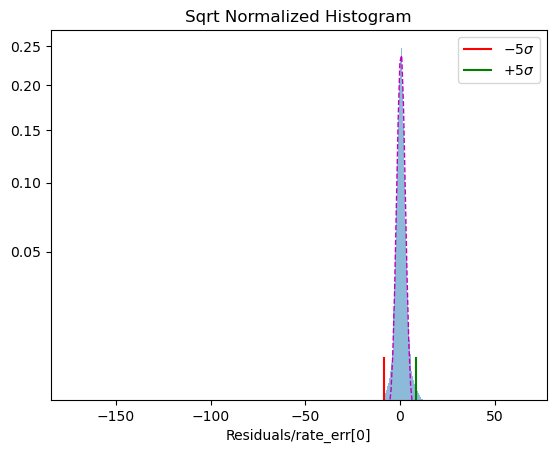

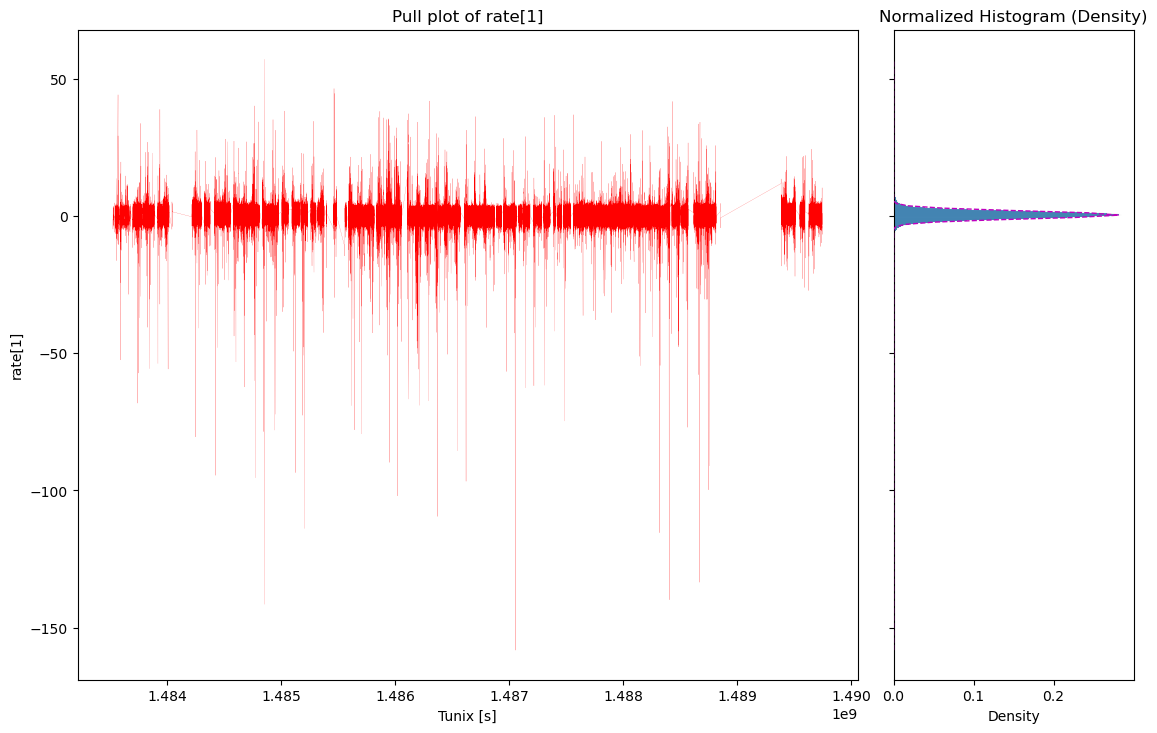

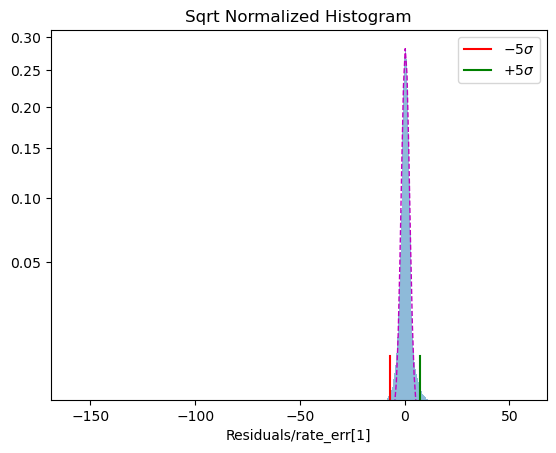

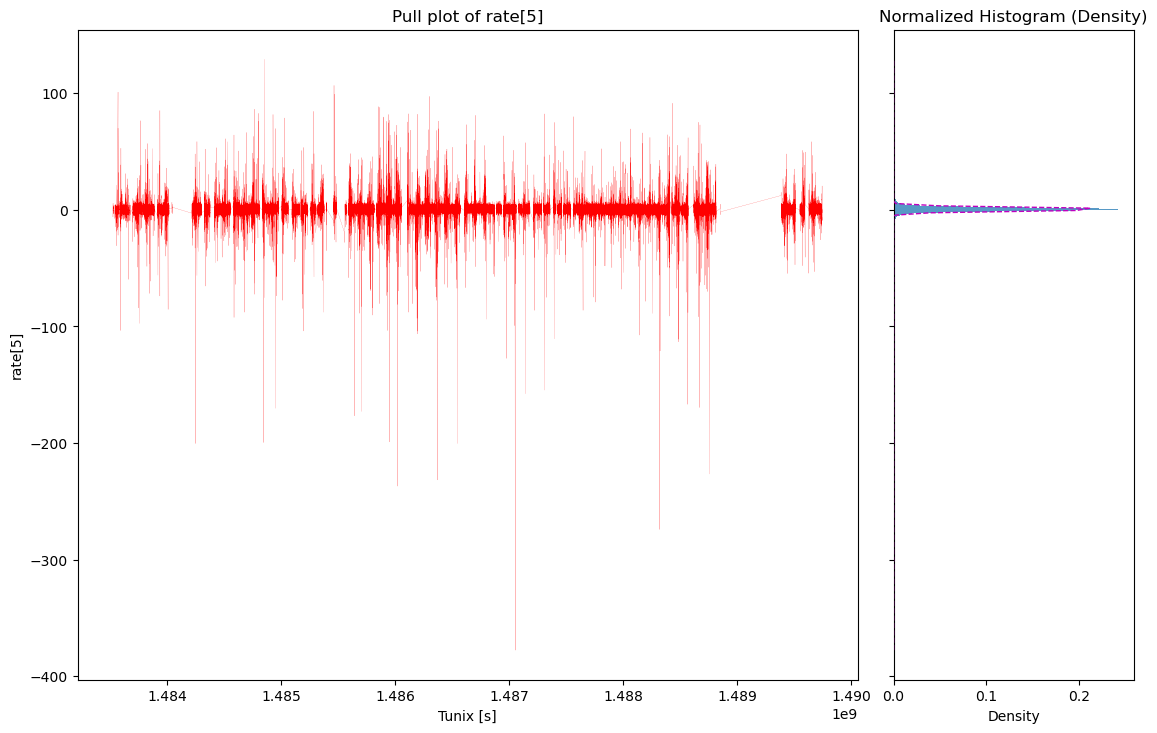

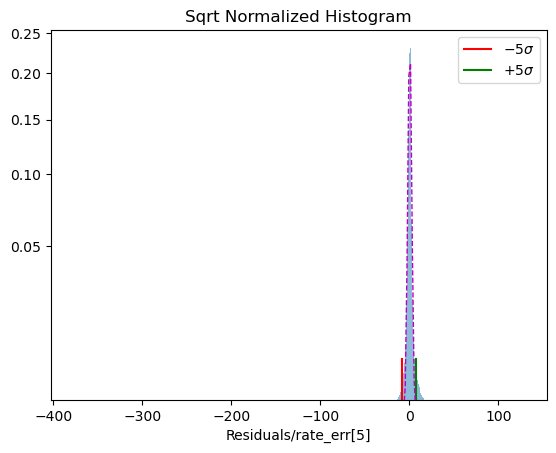

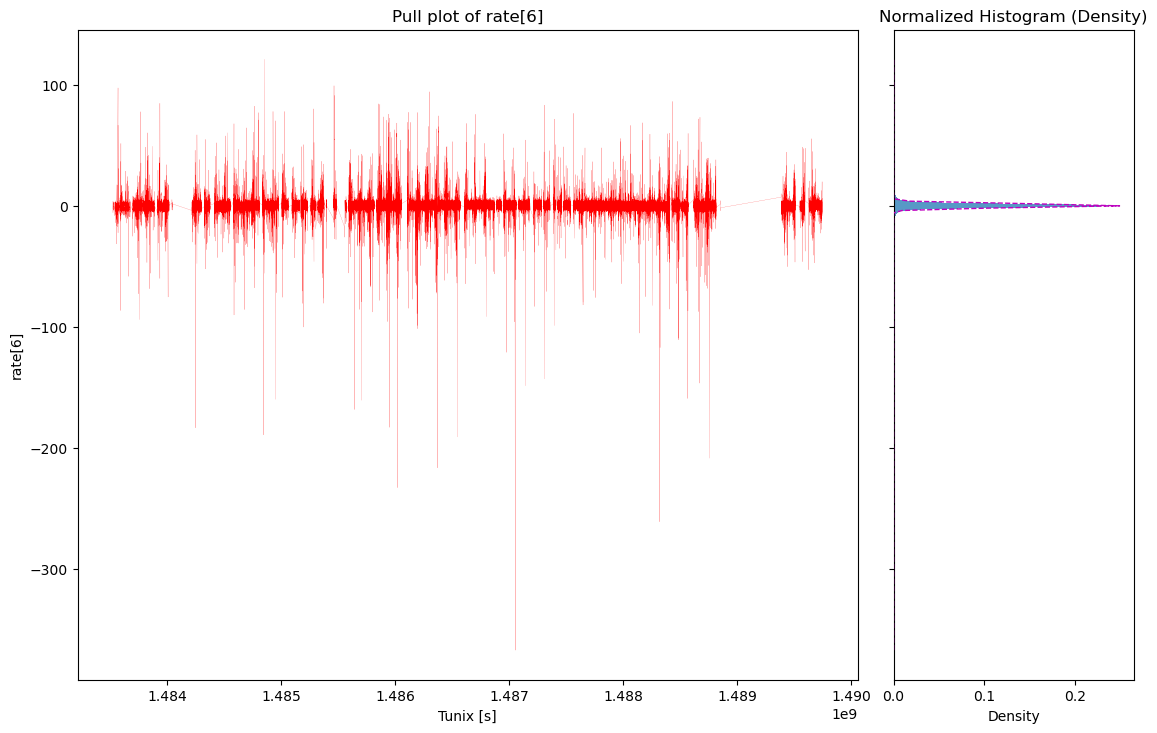

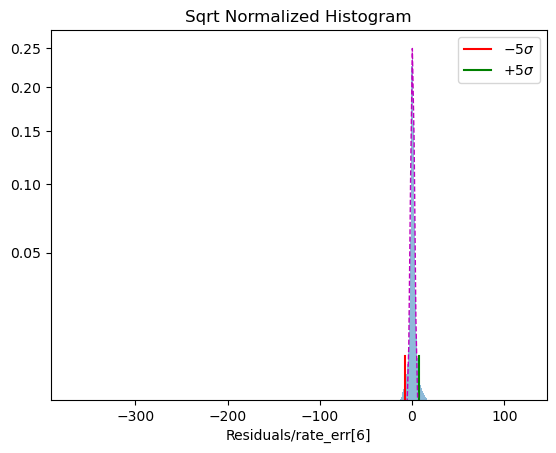

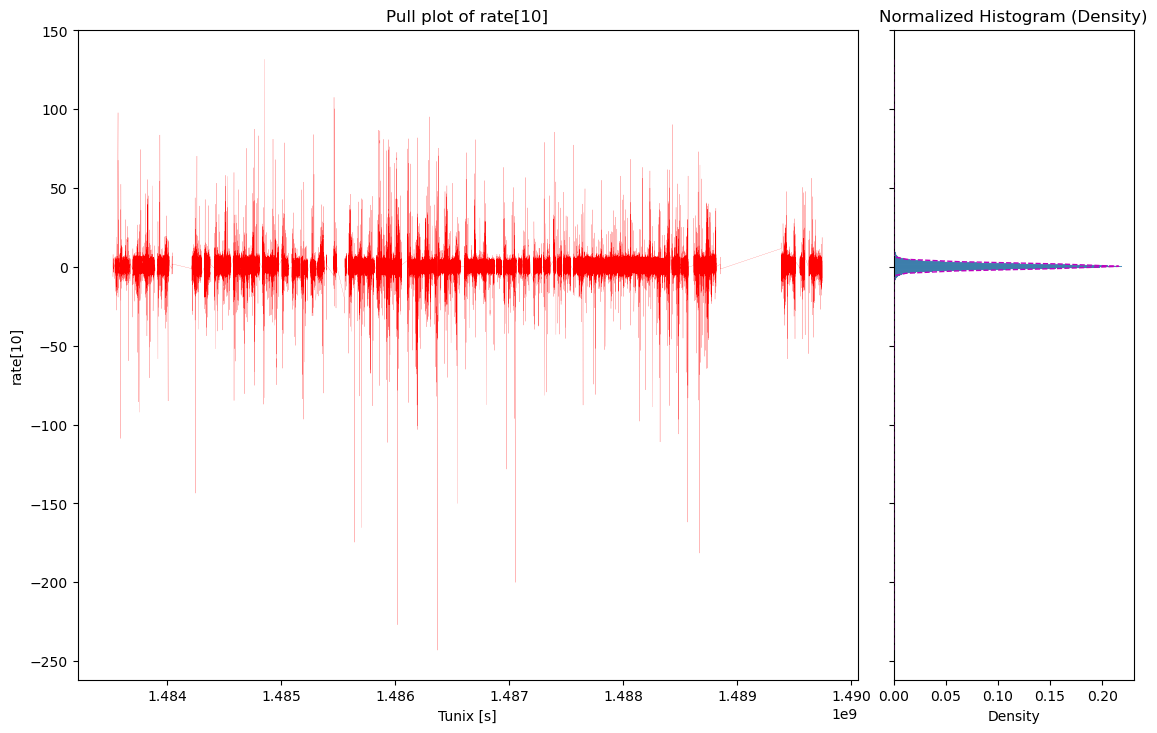

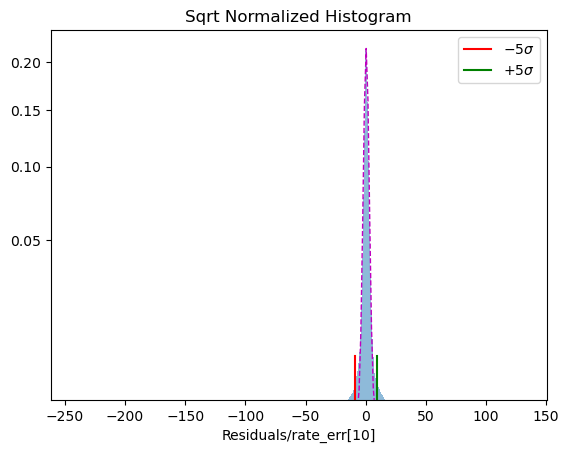

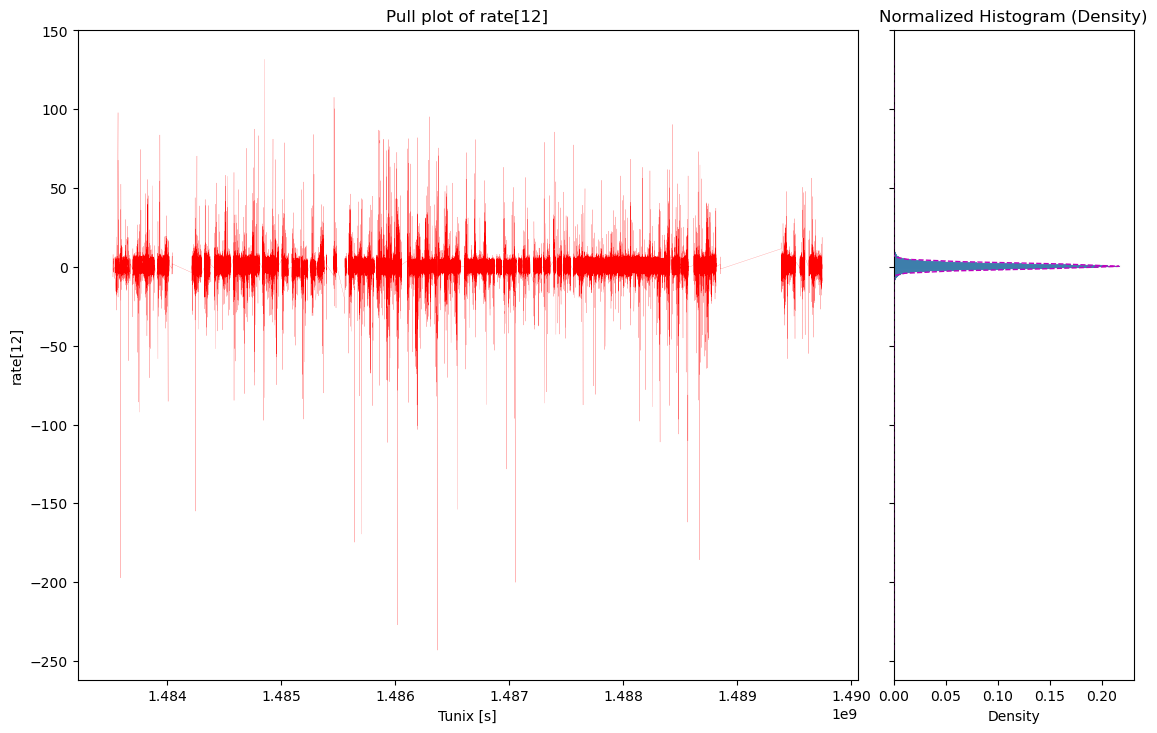

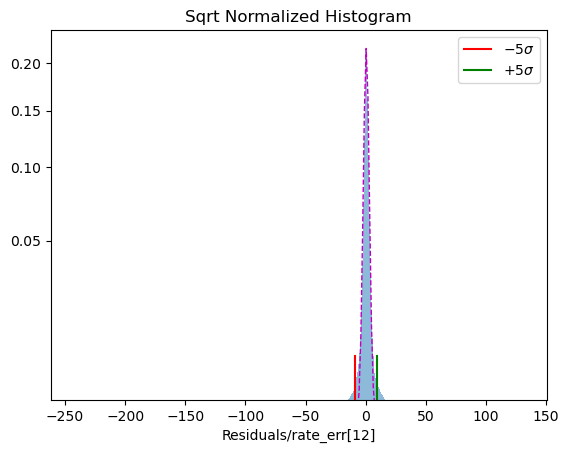

In [7]:
import re
from src.visualizer import plot_val_residual, plot_val_pull

rate_err_names = []
for i, target_name in enumerate(cfg.dataset.target_names):
    # Even though we call the function that has as name "plot_val_residual"
    # we apply it to the whole dataset including GRBs
    if target_name not in [f"rate[{i}]" for i in range(13)]:
        plot_val_residual(subset_dataset_full_GRBs,
                          pred,
                          target_name=target_name,
                          save_path=None,
                          save_path_hist=None)
    else:
        j = re.findall("[0-9]+", target_name)[0]
        rate_err_names.append(f"rate_err[{j}]")
        plot_val_pull(subset_dataset_full_GRBs,
                      pred,
                      target_name=target_name,
                      rate_err_name=rate_err_names[-1],
                      save_path=None,
                      save_path_hist=None)

In [8]:
from src.visualizer import get_all_time_y_y_hat, find_moments, get_columns

tmp = get_all_time_y_y_hat(subset_dataset_full_GRBs, pred)
sorted_time, sorted_y, sorted_y_hat = tmp
del tmp


residuals = sorted_y-sorted_y_hat
var = residuals

tmp = np.isin(cfg.dataset.target_names, [f"rate[{i}]" for i in range(13)])

if ~np.any(tmp):
    print(f"Thresholding using residuals")
    new_mean, new_std = list(zip(*[find_moments(residuals[:, j])\
                                   for j in range(residuals.shape[1])]))
    new_mean, new_std = np.array(new_mean), np.array(new_std)
elif np.all(tmp):
    print("Thresholding using residuals/rate_errs (pull)")
    rate_errs = get_columns(subset_dataset_full_GRBs, rate_err_names)
    pulls = residuals/rate_errs
    new_mean, new_std = list(zip(*[find_moments(pulls[:, j])\
                                   for j in range(pulls.shape[1])]))
    new_mean, new_std = np.array(new_mean), np.array(new_std)
    var = pulls
else:
    raise NotImplementedError("Did not implement the case in which the targets are a mix of rate[i] and other")
del tmp

k = 3
print(np.sum(var > k*new_std, axis=0))    

Thresholding using residuals/rate_errs (pull)
[ 80445  79445 139029 139648 109130 110379]


In [9]:
new_std

array([1.6400112, 1.4144385, 1.6090986, 1.5861137, 1.8475989, 1.8384343],
      dtype=float32)

For `rate[0]`

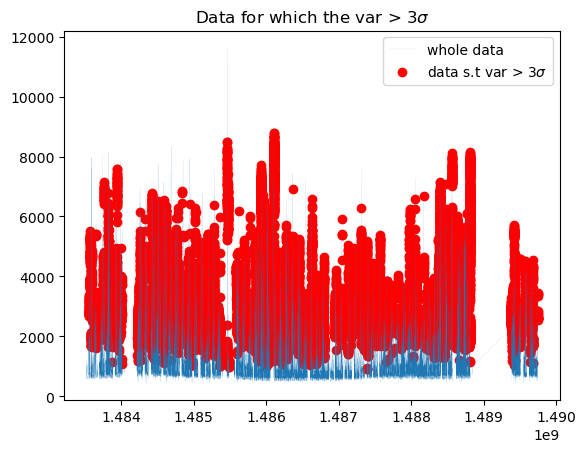

In [10]:
plt.plot(data_df["unix_time"], data_df[cfg.dataset.target_names[0]],
         linewidth=0.05, label="whole data")

plt.scatter(data_df.loc[var[:, 0] > 5*new_std[0], "unix_time"],
         data_df.loc[var[:, 0] > 5*new_std[0], cfg.dataset.target_names[0]],
         color='r', label=fr"data s.t var > ${k}\sigma$")
plt.title(fr"Data for which the var > ${k}\sigma$")
plt.legend()
plt.show()

### GRBs

In [11]:
import pandas as pd

In [12]:
GRBs = pd.read_csv("../data/GRBs.csv")
GRBs

,Number,GRB_Name,Trigger_time_UTC,unix_time
0,1,GRB_160924A,2016-09-24T06:04:09.040,1.474697e+09
1,2,GRB_160928A,2016-09-28T19:48:05.000,1.475092e+09
2,3,GRB_161009651,2016-10-09T15:38:07.190,1.476027e+09
3,4,GRB_161011217,2016-10-11T05:13:44.420,1.476163e+09
4,5,GRB_161012989,2016-10-12T23:45:11.380,1.476316e+09
5,6,GRB_161013948,2016-10-13T22:44:40.100,1.476399e+09
6,7,GRB_161120401,2016-11-20T09:38:33.520,1.479635e+09
7,8,GRB_161129A,2016-11-29T07:11:40.000,1.480404e+09
8,9,GRB_161203A,2016-12-03T18:41:07.750,1.480790e+09
9,10,GRB_161205A,2016-12-05T13:27:18.000,1.480944e+09


Text(0.5, 1.0, '55 GRBs against full dataset')

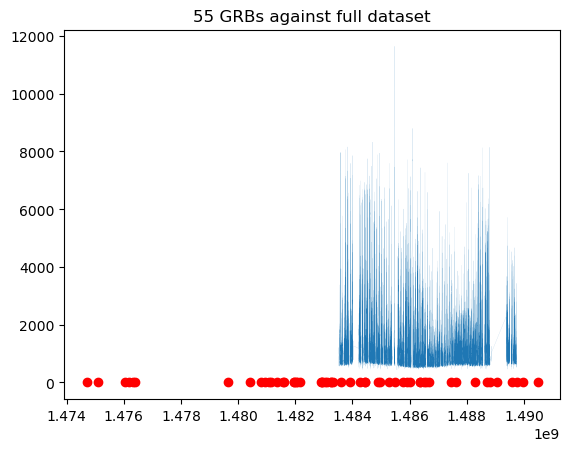

In [13]:
plt.plot(data_df["unix_time"], data_df[cfg.dataset.target_names[0]], linewidth=0.05)
plt.scatter(GRBs["unix_time"], np.zeros_like(GRBs["unix_time"]), color="r")
plt.title("55 GRBs against full dataset")

Let's only take a look at the GRBs happening within the same time range

In [14]:
mask = data_df["unix_time"].min() <= GRBs["unix_time"].values
mask &= GRBs["unix_time"].values <= data_df["unix_time"].max()
print(f"Out of 55, there are: {mask.sum()} GRBs within our time range")

Out of 55, there are: 25 GRBs within our time range


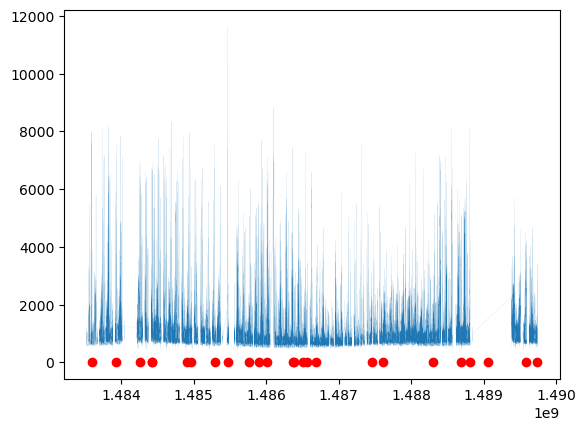

In [15]:
plt.plot(data_df["unix_time"], data_df[cfg.dataset.target_names[0]], linewidth=0.05)
plt.scatter(GRBs["unix_time"][mask], np.zeros_like(GRBs["unix_time"][mask]), color="r")
plt.show()

Zooming into the GRBs with a window of 100 seconds before and 100 seconds after

- (unix_time < 1483596747.0) || (unix_time > 1483596947.0)  # GRB_170105A
- (unix_time < 1483931755.0) || (unix_time > 1483931955.0)  # GRB_170109A
- (unix_time < 1484262869.0) || (unix_time > 1484263069.0)  # GRB_170112B
- (unix_time < 1484431170.0) || (unix_time > 1484431370.0)  # GRB_170114A
- (unix_time < 1484423852.0) || (unix_time > 1484424052.0)  # GRB_170114B
- (unix_time < 1484911010.0) || (unix_time > 1484911210.0)  # GRB_170120A
- (unix_time < 1484962515.2) || (unix_time > 1484962715.2)  # GRB_170121A
- (unix_time < 1485291386.0) || (unix_time > 1485291586.0)  # GRB_170124A
- (unix_time < 1485480849.0) || (unix_time > 1485481049.0)  # GRB_170127C
- (unix_time < 1485760385.0) || (unix_time > 1485760585.0)  # GRB_170130A
- (unix_time < 1485904399.0) || (unix_time > 1485904599.0)  # GRB_170131A
- (unix_time < 1486019894.0) || (unix_time > 1486020094.0)  # GRB_170202B
- (unix_time < 1486378217.7) || (unix_time > 1486378417.7)  # GRB_170206A
- (unix_time < 1486381110.0) || (unix_

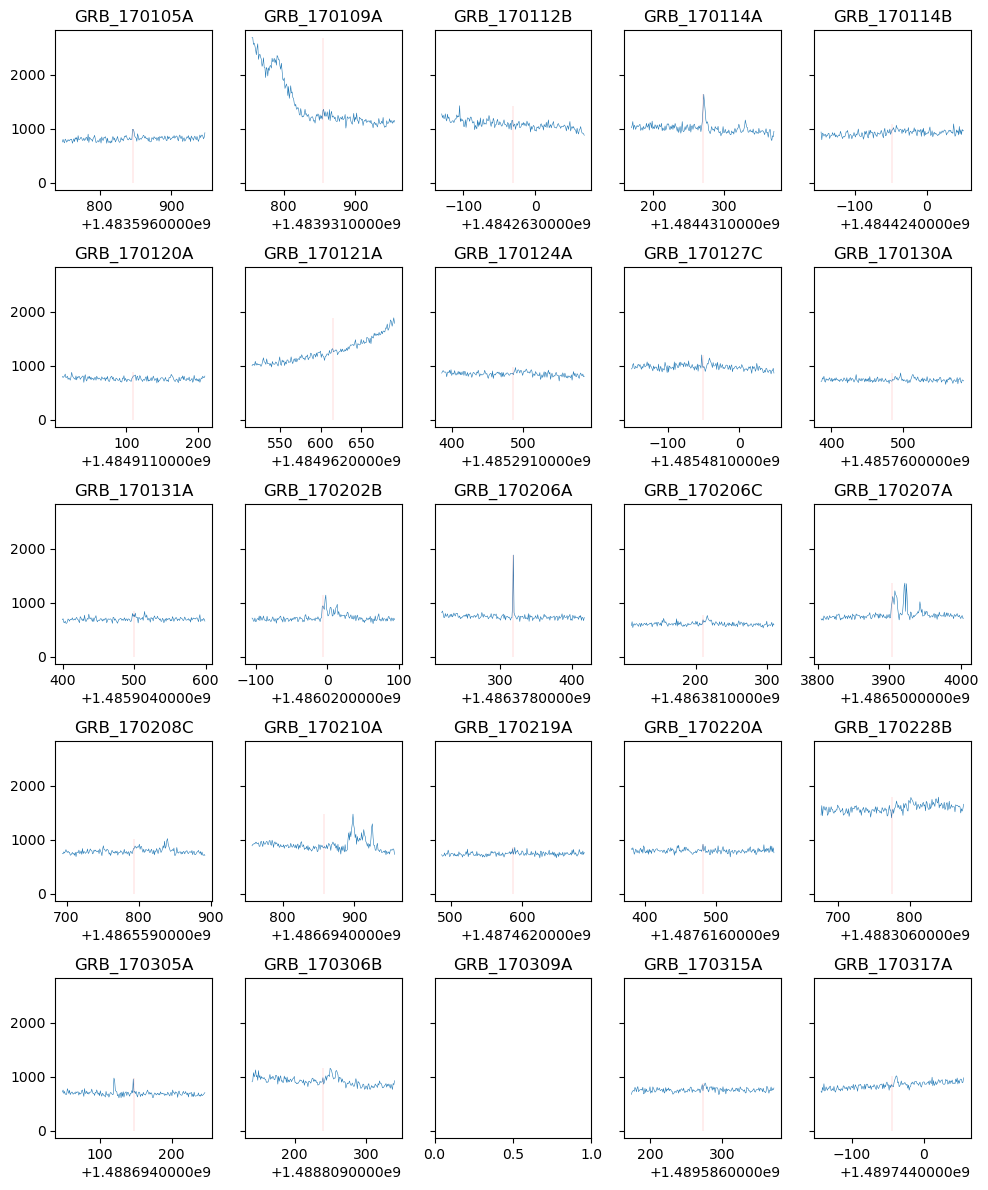

In [16]:
w = 100

fig, axs = plt.subplots(5, 5, figsize=(10, 12), sharey=True)

for i, GRB_name, GRB_tunix in zip(range(mask.sum()),
                        GRBs["GRB_Name"][mask],
                        GRBs["unix_time"][mask]):
    # print(GRB_name, GRB_tunix-w, GRB_tunix+w)
    # print(f"- (unix_time >= {GRB_tunix-w}) & (unix_time <= {GRB_tunix+w})  # {GRB_name}")
    print(f"- (unix_time < {GRB_tunix-w}) || (unix_time > {GRB_tunix+w})  # {GRB_name}")
    m = data_df["unix_time"] >= GRB_tunix-w
    m &= data_df["unix_time"] <= GRB_tunix+w
    
    if m.sum() > 0:
        axs[i//5, i%5].plot(data_df.loc[m, "unix_time"],
                data_df.loc[m, cfg.dataset.target_names[0]], linewidth=0.4)
        axs[i//5, i%5].vlines(GRB_tunix, 0,
                            data_df.loc[m, cfg.dataset.target_names[0]].max(),
                            'r', linewidth=0.1)
    axs[i//5, i%5].set_title(GRB_name)
plt.tight_layout()

Text(0.5, 1.0, 'GRB_170219A')

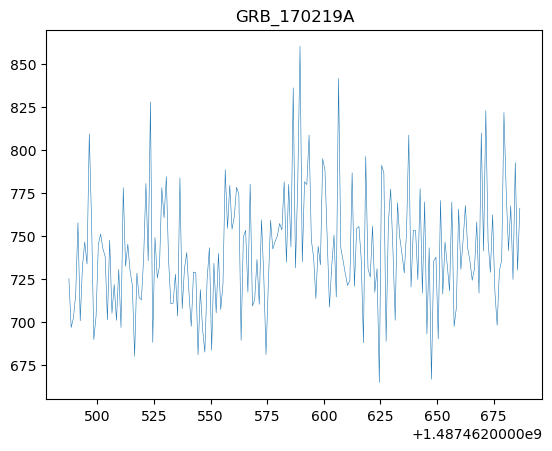

In [17]:
GRB_name = "GRB_170219A"
GRB_tunix = float(GRBs[GRBs["GRB_Name"]==GRB_name]["unix_time"])
m = data_df["unix_time"] >= GRB_tunix-w
m &= data_df["unix_time"] <= GRB_tunix+w

plt.plot(data_df.loc[m, "unix_time"],
        data_df.loc[m, cfg.dataset.target_names[0]], linewidth=0.4)
# plt.vlines(GRB_tunix, 0,
#         data_df.loc[m, cfg.dataset.target_names[0]].max(),
#         'r', linewidth=0.1)
plt.title(GRB_name)

In [18]:
GRBs[GRBs["GRB_Name"]=="GRB_170219A"]

,Number,GRB_Name,Trigger_time_UTC,unix_time
45,46,GRB_170219A,2017-02-19T00:03:07.000,1.487463e+09


Comparing with where our algo fails for `rate[0]`

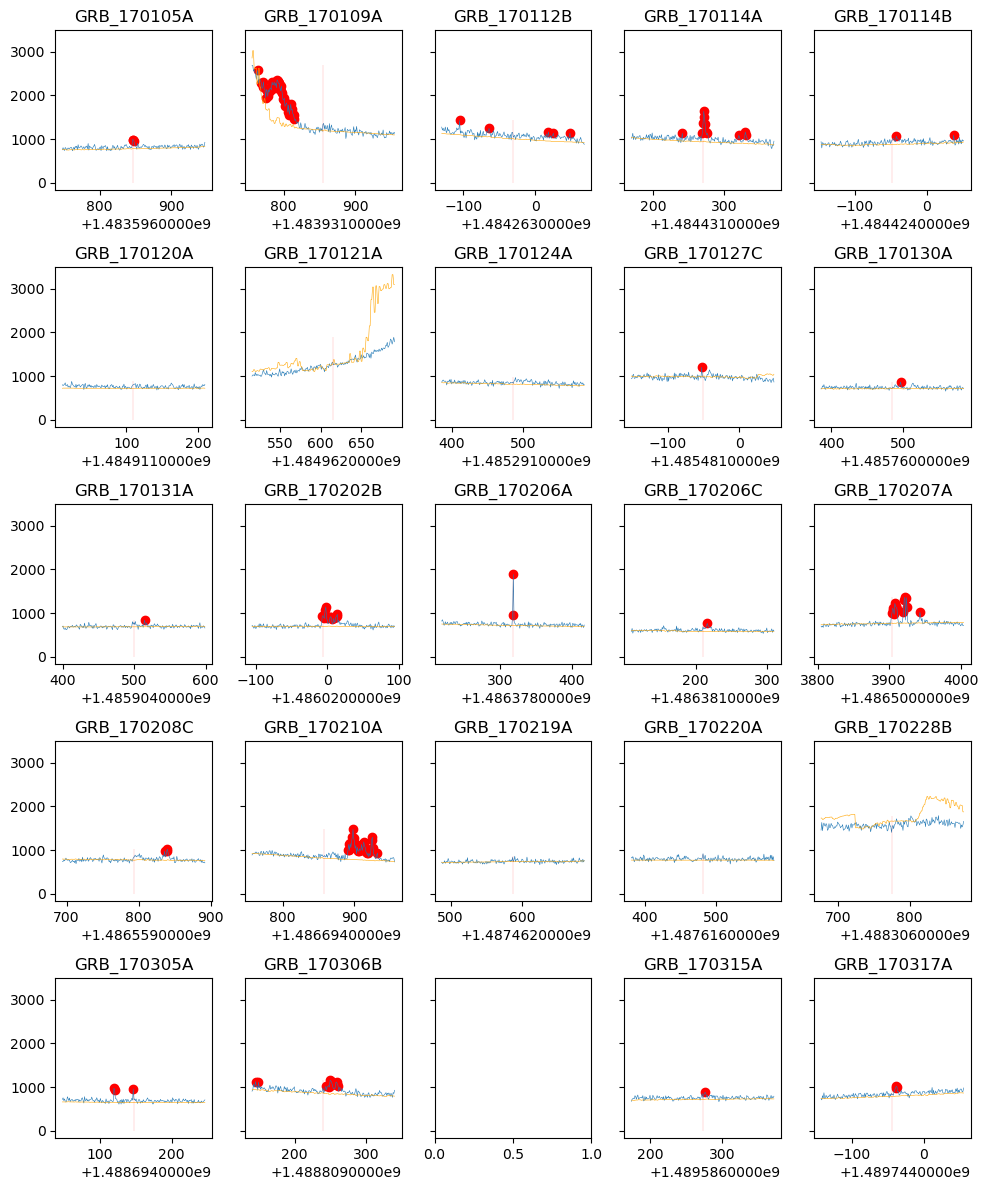

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(10, 12), sharey=True)

for i, GRB_name, GRB_tunix in zip(range(mask.sum()),
                        GRBs["GRB_Name"][mask],
                        GRBs["unix_time"][mask]):
     m = data_df["unix_time"] >= GRB_tunix-w
     m &= data_df["unix_time"] <= GRB_tunix+w
     m = m.values

     mvar = data_df["unix_time"] >= GRB_tunix-w
     mvar &= data_df["unix_time"] <= GRB_tunix+w
     mvar &= (var[:, 0] > k*new_std[0])
     if m.sum() > 0:
          axs[i//5, i%5].plot(data_df[m]["unix_time"],
                    data_df[m][cfg.dataset.target_names[0]], linewidth=0.4)
          axs[i//5, i%5].plot(data_df[m]["unix_time"],
                              pred[:, 0][m].detach().cpu(), 'orange', linewidth=0.4)
          axs[i//5, i%5].vlines(GRB_tunix, 0,
                                data_df[m][cfg.dataset.target_names[0]].max(),
                                'r', linewidth=0.1)
          axs[i//5, i%5].set_title(GRB_name)
     if mvar.sum() > 0:
          axs[i//5, i%5].scatter(data_df.loc[mvar, "unix_time"],
               data_df.loc[mvar, cfg.dataset.target_names[0]],
               color='r', label=fr"data s.t var > ${k}\sigma$")
plt.tight_layout()

Looking at the pulls

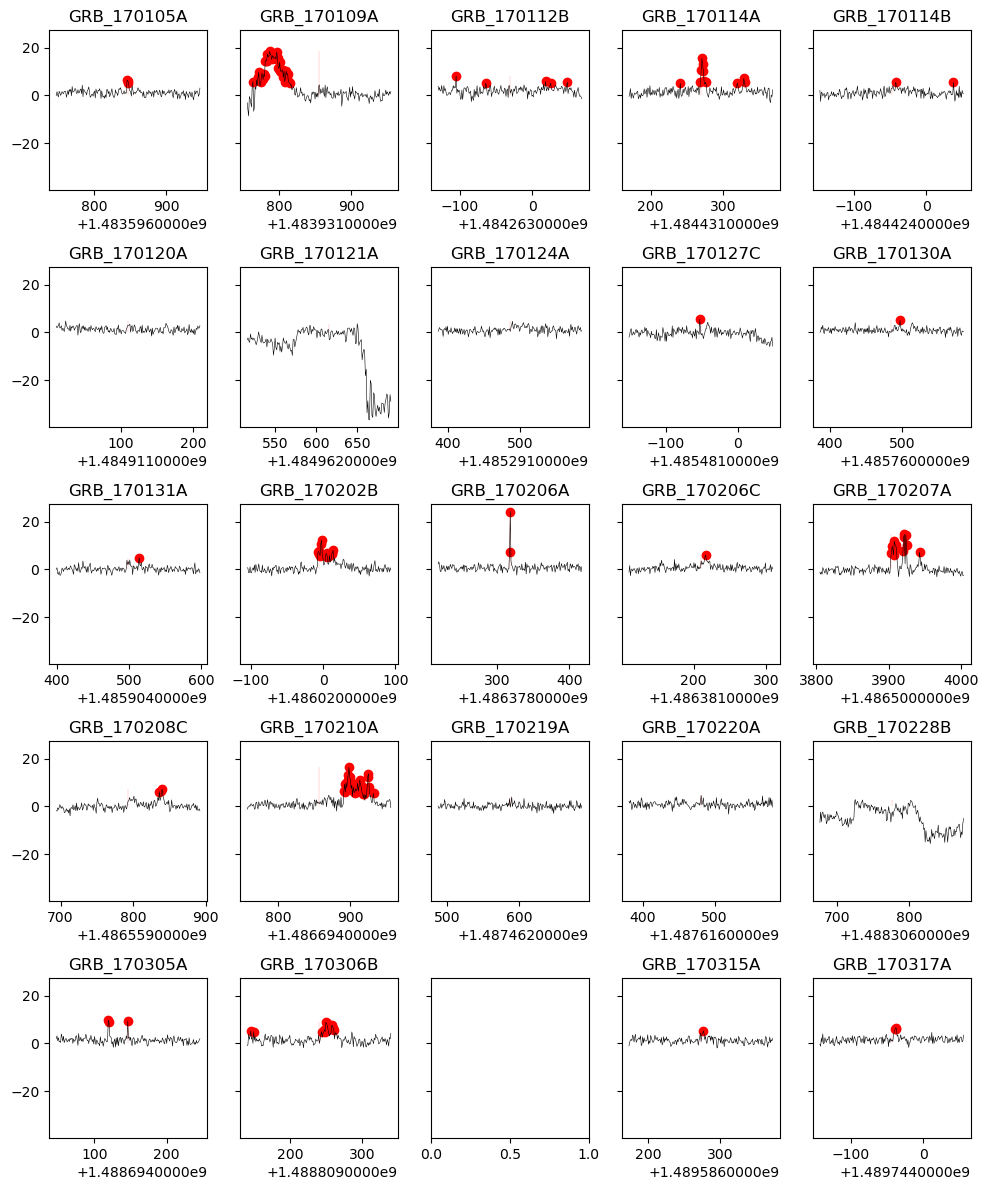

In [20]:
fig, axs = plt.subplots(5, 5, figsize=(10, 12), sharey=True)

for i, GRB_name, GRB_tunix in zip(range(mask.sum()),
                        GRBs["GRB_Name"][mask],
                        GRBs["unix_time"][mask]):
     m = data_df["unix_time"] >= GRB_tunix-w
     m &= data_df["unix_time"] <= GRB_tunix+w
     m = m.values

     mvar = data_df["unix_time"] >= GRB_tunix-w
     mvar &= data_df["unix_time"] <= GRB_tunix+w
     mvar &= (var[:, 0] > k*new_std[0])
     if m.sum() > 0:
          axs[i//5, i%5].plot(data_df[m]["unix_time"],
                              var[:, 0][m], 'k', linewidth=0.4)
          axs[i//5, i%5].vlines(GRB_tunix, 0,
                                var[:, 0][m].max(),
                                'r', linewidth=0.1)
          axs[i//5, i%5].set_title(GRB_name)
     if mvar.sum() > 0:
          axs[i//5, i%5].scatter(data_df.loc[mvar, "unix_time"],
                                 var[:, 0][mvar],
                                 color='r', label=fr"data s.t var > ${k}\sigma$")
plt.tight_layout()

In [21]:
# Red points of interest
points = data_df.loc[(var[:, 0] > k*new_std[0]), "unix_time"]
points = points.reset_index(drop=True)
points

0        1.483528e+09
1        1.483542e+09
2        1.483548e+09
3        1.483550e+09
4        1.483556e+09
             ...     
80440    1.489745e+09
80441    1.489745e+09
80442    1.489745e+09
80443    1.489745e+09
80444    1.489745e+09
Name: unix_time, Length: 80445, dtype: float64

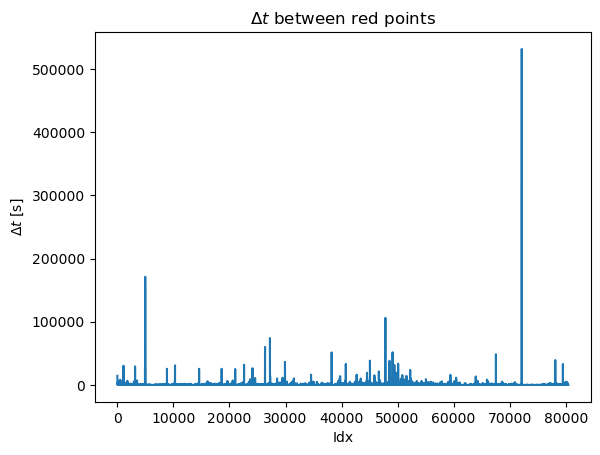

In [22]:
plt.plot(points.values[1:]-points.values[:-1])
plt.title(r"$\Delta t$ between red points")
plt.xlabel("Idx")
plt.ylabel(r"$\Delta t$ [s]")
plt.show()

We can use them to determine "begin and end" of clusters. Note that the huge spike on the right is due to the missing data.

In [23]:
delta = (points.values[1:]-points.values[:-1]).astype(int)
delta = np.concatenate([np.array([np.inf]), delta])

starts = points.loc[delta > 1]
print(starts.shape)

# idx_ends not just starts.index.values[1:] as it would take way
# too big ranges due to delta > 1
idx_ends = starts.index.values[1:] - 1
idx_ends = np.concatenate([idx_ends, [points.size-1]])  # include last data point

ends = points.iloc[idx_ends]
print(ends.shape)

(26573,)
(26573,)


The length of `starts` or `ends` indicates the number of clusters.

Adding a label to each group/cluster:

In [24]:
idx_starts = starts.index.values
groups = np.repeat(np.arange(len(idx_starts))+1, idx_ends - idx_starts + 1)
groups[:100]


array([ 1,  2,  3,  4,  5,  6,  7,  7,  8,  9, 10, 11, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15,
       16, 17, 18, 19, 20, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22])

In [25]:
data = data_df.loc[(var[:, 0] > k*new_std[0])]
data["group"] = groups

/tmp/ipykernel_1601678/1117862665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["group"] = groups


In [26]:
integral = data.groupby("group")["rate[0]"].sum().values


Here is the length of the clusters in time duration (seconds):

In [27]:
lengths = ends.values-starts.values
lengths

array([0.        , 0.        , 0.        , ..., 1.00028014, 0.        ,
       1.00000334])

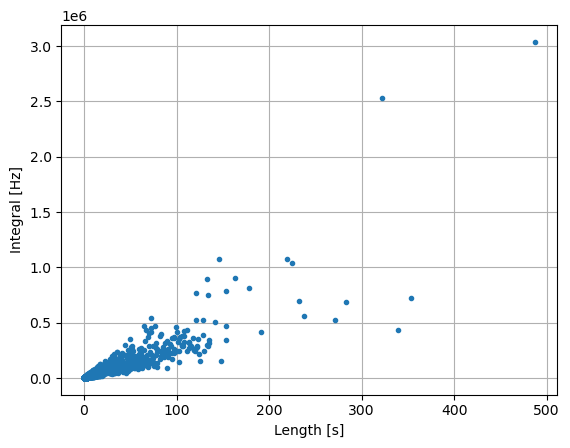

In [28]:
plt.plot(lengths, integral, '.')
plt.xlabel("Length [s]")
plt.ylabel("Integral [Hz]")
plt.grid("on")

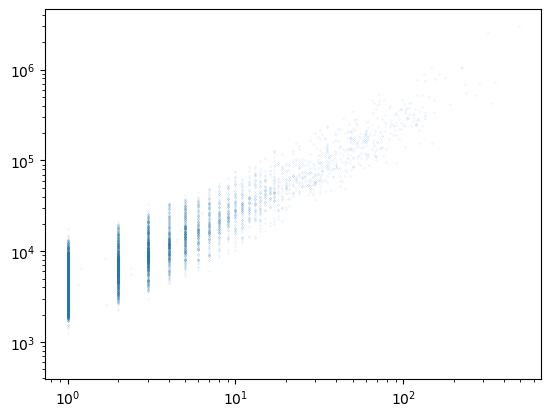

In [29]:
plt.loglog(lengths, integral, '.', markersize=0.1)

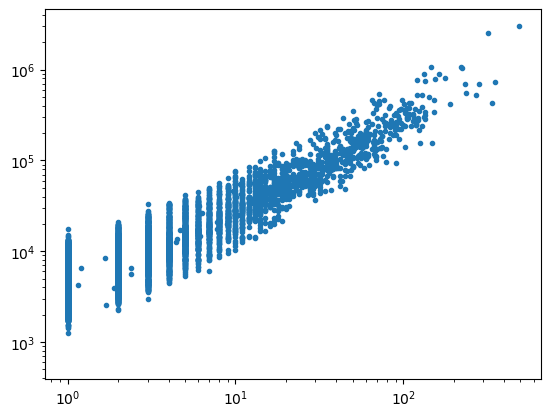

In [30]:
plt.loglog(lengths[integral > 5], integral[integral > 5], '.')